In [1]:
from astroquery.vizier import Vizier as Vizier
from astroquery.skyview import SkyView
import astropy.units as u
import astropy.coordinates as coord
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")
from astropy.coordinates import SkyCoord
import io
import requests
from astropy.table import Table
from PIL import Image
import requests
from io import BytesIO
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
from matplotlib.patches import Circle
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import metrics
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, mean_squared_error
from tensorflow import keras

In [2]:
np.random.RandomState(10)

RandomState(MT19937) at 0x215EEDFCD40

# 1. Data Preprocessing

# 1.0 Load, clean and fix non numeric columns

In [3]:
#laod data
clust_verified = pd.read_csv('verified candidates.csv')

In [4]:
clust_verified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Glon               740 non-null    float64
 1   Glat               740 non-null    float64
 2   comments           120 non-null    object 
 3   3_6mag             740 non-null    float64
 4   e_3_6mag           740 non-null    float64
 5   4_5mag             740 non-null    float64
 6   e_4_5mag           740 non-null    float64
 7   size               740 non-null    float64
 8   sources_cluster    740 non-null    int64  
 9   tile               740 non-null    object 
 10  color_bin          740 non-null    object 
 11  sources_20_arcmin  740 non-null    int64  
 12  sources_tile       740 non-null    int64  
 13  significance       740 non-null    float64
 14  overdensity        740 non-null    float64
dtypes: float64(9), int64(3), object(3)
memory usage: 86.8+ KB


In [5]:
#check columns
clust_verified.columns

Index(['Glon', 'Glat', 'comments', '3_6mag', 'e_3_6mag', '4_5mag', 'e_4_5mag',
       'size', 'sources_cluster', 'tile', 'color_bin', 'sources_20_arcmin',
       'sources_tile', 'significance', 'overdensity'],
      dtype='object')

In [6]:
clust_verified.head()

,Glon,Glat,comments,3_6mag,e_3_6mag,4_5mag,e_4_5mag,size,sources_cluster,tile,color_bin,sources_20_arcmin,sources_tile,significance,overdensity
0,330.0379,1.0447,G3CC_32,13.222647,0.089588,11.842412,0.107118,0.006057,17,split_295.0_335.0/35_4.csv,0.6-4.0,339,209364,3.460917,7.16
1,15.0326,0.8518,NaN,13.869500,0.126571,12.553929,0.133786,0.045419,14,split_15.0_35.0/0_4.csv,0.6-4.0,49,66741,0.673157,2.18
2,350.1153,0.0960,G3CC_44,13.287500,0.115714,11.979643,0.112786,0.011990,14,split_350.0_360.0/0_4.csv,0.6-4.0,443,373558,1.077837,7.35
3,34.4604,0.2480,NaN,13.879467,0.129267,12.598800,0.139333,0.012455,15,split_15.0_35.0/19_3.csv,0.6-4.0,592,208736,1.487271,3.32
4,12.8968,0.4890,NaN,12.929737,0.111105,11.650474,0.139211,0.014854,19,split_0.0_15.0/12_5.csv,0.6-4.0,316,157738,1.817078,4.00


Check for NaN and $\inf$ values

In [7]:
for c in clust_verified.columns:
    print('NaN values in column ',c,'=',clust_verified[c].isna().sum())
    
for c in clust_verified.columns:
    print('Infinity values in column ',c, ': ', len(np.where(clust_verified[c]==np.inf)[0]))

NaN values in column  Glon = 0
NaN values in column  Glat = 0
NaN values in column  comments = 620
NaN values in column  3_6mag = 0
NaN values in column  e_3_6mag = 0
NaN values in column  4_5mag = 0
NaN values in column  e_4_5mag = 0
NaN values in column  size = 0
NaN values in column  sources_cluster = 0
NaN values in column  tile = 0
NaN values in column  color_bin = 0
NaN values in column  sources_20_arcmin = 0
NaN values in column  sources_tile = 0
NaN values in column  significance = 0
NaN values in column  overdensity = 0
Infinity values in column  Glon :  0
Infinity values in column  Glat :  0
Infinity values in column  comments :  0
Infinity values in column  3_6mag :  0
Infinity values in column  e_3_6mag :  0
Infinity values in column  4_5mag :  0
Infinity values in column  e_4_5mag :  0
Infinity values in column  size :  0
Infinity values in column  sources_cluster :  0
Infinity values in column  tile :  0
Infinity values in column  color_bin :  0
Infinity values in column 

1. The column 'comments' is structured in such a way that NaN values are candidates which are not assigned any clusters and known clusters have a string value with name of the cluster. 

2. To work with ML algorithms we need numerical values, so logically we'll assign a numeral value of '1' to known clusters and '0' to unknown candidates (candidates having NaN values).

3. There is one infinity value in *overdensity*, we'll replace it with a large number, 99

In [8]:
clust_verified['comments'].fillna(0, inplace=True)
for i in range(clust_verified.shape[0]):
    if clust_verified['comments'][i] != 0:
        clust_verified['comments'][i] = 1
        
clust_verified['overdensity'][clust_verified['overdensity']==np.inf] = 99

Check NaN and $\inf$ values again

In [9]:
for c in clust_verified.columns:
    print('NaN values in column ',c,'=',clust_verified[c].isna().sum())
    
for c in clust_verified.columns:
    print('Infinity values in column ',c, ': ', len(np.where(clust_verified[c]==np.inf)[0]))

NaN values in column  Glon = 0
NaN values in column  Glat = 0
NaN values in column  comments = 0
NaN values in column  3_6mag = 0
NaN values in column  e_3_6mag = 0
NaN values in column  4_5mag = 0
NaN values in column  e_4_5mag = 0
NaN values in column  size = 0
NaN values in column  sources_cluster = 0
NaN values in column  tile = 0
NaN values in column  color_bin = 0
NaN values in column  sources_20_arcmin = 0
NaN values in column  sources_tile = 0
NaN values in column  significance = 0
NaN values in column  overdensity = 0
Infinity values in column  Glon :  0
Infinity values in column  Glat :  0
Infinity values in column  comments :  0
Infinity values in column  3_6mag :  0
Infinity values in column  e_3_6mag :  0
Infinity values in column  4_5mag :  0
Infinity values in column  e_4_5mag :  0
Infinity values in column  size :  0
Infinity values in column  sources_cluster :  0
Infinity values in column  tile :  0
Infinity values in column  color_bin :  0
Infinity values in column  s

**But the conversion has led to the data type of 'comments' column as *object* which must be converted to integer (*int*)**

In [10]:
clust_verified['comments'] = clust_verified['comments'].astype(str).astype(int)
clust_verified.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Glon               740 non-null    float64
 1   Glat               740 non-null    float64
 2   comments           740 non-null    int32  
 3   3_6mag             740 non-null    float64
 4   e_3_6mag           740 non-null    float64
 5   4_5mag             740 non-null    float64
 6   e_4_5mag           740 non-null    float64
 7   size               740 non-null    float64
 8   sources_cluster    740 non-null    int64  
 9   tile               740 non-null    object 
 10  color_bin          740 non-null    object 
 11  sources_20_arcmin  740 non-null    int64  
 12  sources_tile       740 non-null    int64  
 13  significance       740 non-null    float64
 14  overdensity        740 non-null    float64
dtypes: float64(9), int32(1), int64(3), object(2)
memory usage: 84.0+ KB


We should select the columns which are relevant with our analysis. For e.g. the galactic coordinates of a cluster is not very relevant to our analysis, so we could drop it. The 'color_bin' is same for all the sources, so it can be dropped to reduce the unnecesary complexities. The 'tile' column just says what tile was used for a particular cluster so it's not relevant either.

In [11]:
attr = ['3_6mag', 'e_3_6mag', '4_5mag', 'e_4_5mag', 'size',
       'sources_cluster', 'sources_20_arcmin',
       'sources_tile', 'significance', 'overdensity', 'comments']

In [12]:
#processed dataset
clusters = clust_verified[attr]

# 1.1 Principal Component Analysis (PCA)

In [13]:
from sklearn.decomposition import PCA

Scale the data before using PCA to make it uniform

In [14]:
X= clusters.drop('comments', axis=1)
scaled_data = StandardScaler().fit_transform(clusters)
X_scaled = StandardScaler().fit_transform(X)

pca2 = PCA(n_components=2)
pca4 = PCA(n_components=4)

In [15]:
pca_comp2 = pca2.fit_transform(X_scaled)
pca_comp4 = pca4.fit_transform(X_scaled)

In [16]:
pca_comp2 = pd.DataFrame(pca_comp2, columns=['pc1', 'pc2'])
pca_comp4 = pd.DataFrame(pca_comp4, columns=['pc1', 'pc2', 'pc3', 'pc4'])

<Figure size 432x288 with 0 Axes>

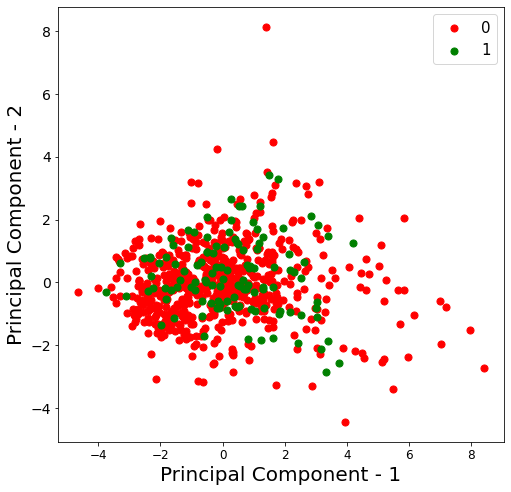

In [17]:
plt.figure()
plt.figure(figsize=(8,8))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = clusters['comments'] == target
    plt.scatter(pca_comp2.loc[indicesToKeep, 'pc1']
               , pca_comp2.loc[indicesToKeep, 'pc2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})

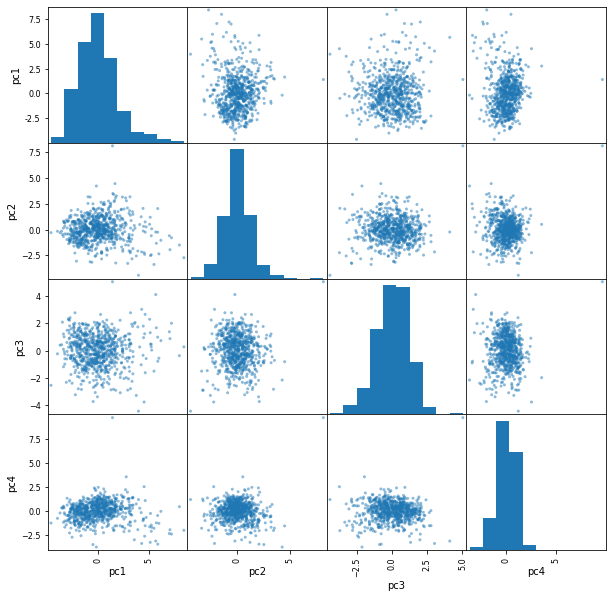

In [18]:
scatter_matrix(pca_comp4, figsize=(10,10))
plt.show()

In [19]:
#variance ratio
pca2.explained_variance_ratio_

array([0.37175677, 0.14867151])

Dimensionality Reduction using PCA does not work and we loose a lot of data instead (from variance ratio). So, let's visualize the data and features.

# 1.2 Data Visualization

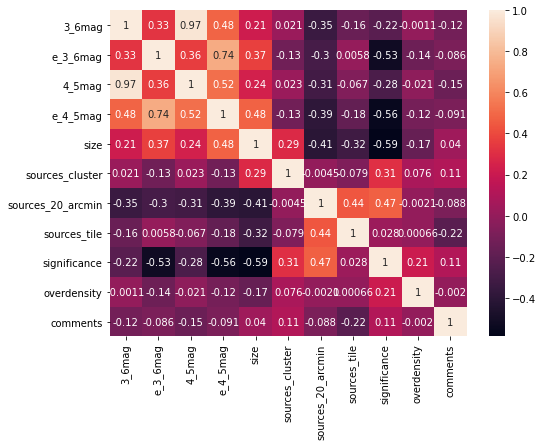

In [20]:
corr = clusters.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True)
plt.show()

Sorting the correlation coefficient with our label

In [21]:
corr['comments'].sort_values(ascending=False)

comments             1.000000
sources_cluster      0.111505
significance         0.106766
size                 0.039865
overdensity         -0.002040
e_3_6mag            -0.085941
sources_20_arcmin   -0.088102
e_4_5mag            -0.091063
3_6mag              -0.120361
4_5mag              -0.150275
sources_tile        -0.220748
Name: comments, dtype: float64

Negative correlation coefficient shows the negative slope, so an absolute value of these coefficients are good indicator of the correlation. Let's do a pairplot of the features to gain more insights on the attributes.

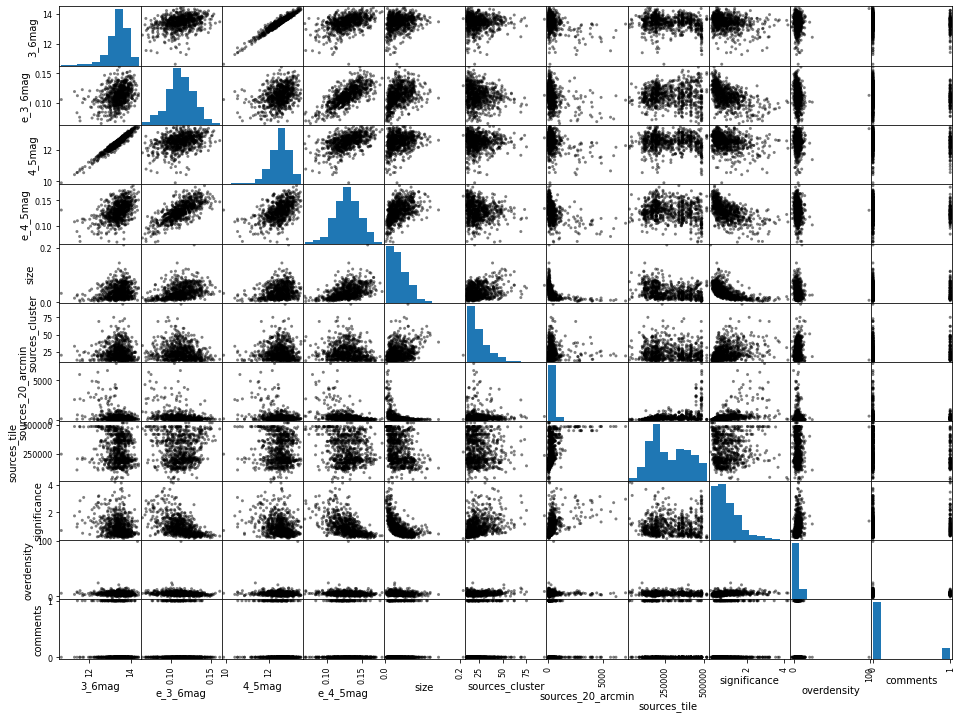

In [22]:
scatter_matrix(clusters, figsize=(16,12), c='black')
plt.show()

We can see a linear relation between 3_6mag and 4_5mag and this is expected because they are IRAC bands from *Spitzer*, it's a good idea to introduce a new feature *color* which is defined as **color = 3_6mag - 4_5mag**

In [23]:
clusters['color'] = clusters['3_6mag']-clusters['4_5mag']

In [24]:
corr = clusters.corr()
corr['comments'].sort_values(ascending=False)

comments             1.000000
color                0.151928
sources_cluster      0.111505
significance         0.106766
size                 0.039865
overdensity         -0.002040
e_3_6mag            -0.085941
sources_20_arcmin   -0.088102
e_4_5mag            -0.091063
3_6mag              -0.120361
4_5mag              -0.150275
sources_tile        -0.220748
Name: comments, dtype: float64

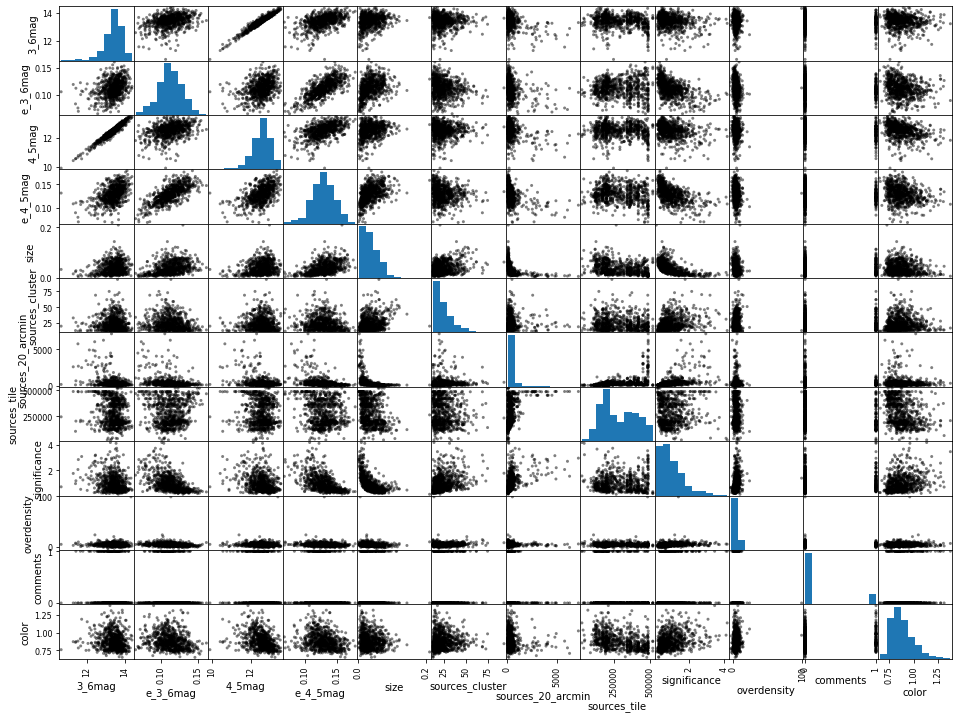

In [25]:
scatter_matrix(clusters, figsize=(16,12), c='black')
plt.show()

Except for ***ovedensity*** all features seem to be decently correlated and some of them better correlated. This is to be expected because we used overdensity to find out clusters using the clustering algorithm in the first place, so the potential clusters have same level of overdensity.

In [26]:
clusters_copy = clusters.copy()

clusters = clusters.drop('overdensity', axis=1)

# 1.3 Splitting data into train and test sets

We split the data into training and test sets to apply it on the ML algorithms. We use StratifiedShuffleSplit instead of train_test_split as it divides the data based on the ratio of the labels and the model training and accuracy improves.

In [27]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=10)
for train_index, test_index in split.split(clusters, clusters["comments"]):
    strat_train_set = clusters.loc[train_index]
    strat_test_set = clusters.loc[test_index]
X_train = strat_train_set.drop('comments', axis=1)
y_train = strat_train_set['comments']
X_test = strat_test_set.drop('comments', axis=1)
y_test = strat_test_set['comments']

# 2. Training the data on ML Algorithms 

Scaling the data

In [28]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# 2.0 Sklearn classifiers

In [29]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Support Vector Machines
from sklearn.svm import LinearSVC
models['Support Vector Machines'] = LinearSVC()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

# Naive Bayes
from sklearn.naive_bayes import GaussianNB
models['Naive Bayes'] = GaussianNB()

# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy, precision, recall = {}, {}, {}

for key in models.keys():
    
    # Fit the classifier
    models[key].fit(X_train, y_train)
    
    # Make predictions
    predictions = models[key].predict(X_test)
    
    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test)
    recall[key] = recall_score(predictions, y_test)

In [31]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.855856,0.111111,1.000000
Support Vector Machines,0.837838,0.000000,0.000000
Decision Trees,0.729730,0.222222,0.200000
Random Forest,0.873874,0.222222,1.000000
Naive Bayes,0.783784,0.555556,0.384615
K-Nearest Neighbor,0.846847,0.222222,0.571429


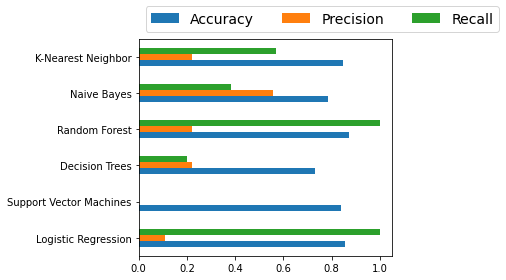

In [32]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()), 
    bbox_to_anchor=(0, 1), 
    loc='lower left', 
    prop={'size': 14}
)
plt.tight_layout()

Model:  Logistic Regression
True Positive(TP)  =  2
False Positive(FP) =  0
True Negative(TN)  =  93
False Negative(FN) =  16


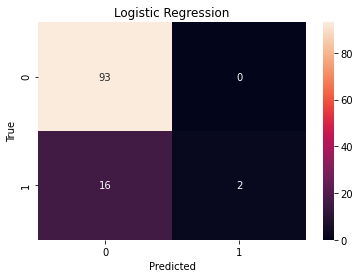

Model:  Support Vector Machines
True Positive(TP)  =  0
False Positive(FP) =  0
True Negative(TN)  =  93
False Negative(FN) =  18


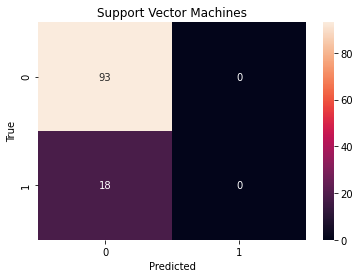

Model:  Decision Trees
True Positive(TP)  =  4
False Positive(FP) =  16
True Negative(TN)  =  77
False Negative(FN) =  14


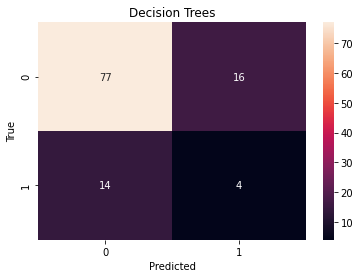

Model:  Random Forest
True Positive(TP)  =  4
False Positive(FP) =  0
True Negative(TN)  =  93
False Negative(FN) =  14


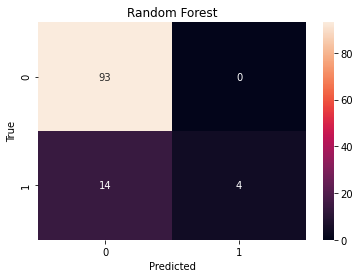

Model:  Naive Bayes
True Positive(TP)  =  10
False Positive(FP) =  16
True Negative(TN)  =  77
False Negative(FN) =  8


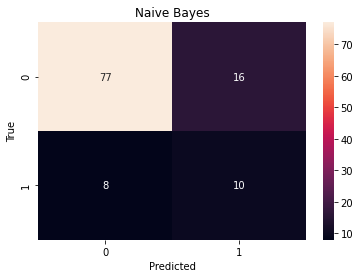

Model:  K-Nearest Neighbor
True Positive(TP)  =  4
False Positive(FP) =  3
True Negative(TN)  =  90
False Negative(FN) =  14


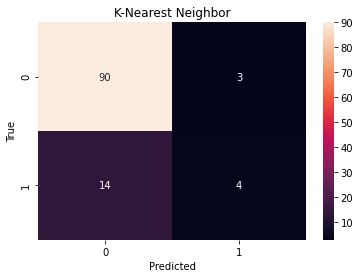

In [33]:
for m in models:
    print("Model: ", m)
    y_pred = models[m].predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

    print('True Positive(TP)  = ', TP)
    print('False Positive(FP) = ', FP)
    print('True Negative(TN)  = ', TN)
    print('False Negative(FN) = ', FN)

    sns.heatmap(cm, annot=True)
    plt.title(m)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# 2.0.1 Hyperparameter tuning on RandomForest 

Let us tune the hyperparameter of RandomForestClassifier to get an optimum value for the parameter

In [34]:
param_grid = { 
    'n_estimators': [1, 5, 10, 100],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [4,6,8,10],
    'criterion' :['gini', 'entropy']
}

In [35]:
rf_grid = GridSearchCV(estimator=models['Random Forest'], param_grid=param_grid, cv=5, verbose=5, scoring='balanced_accuracy')

In [36]:
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=1 ..
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=1, score=0.611, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=1 ..
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=1, score=0.472, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=1 ..
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=1, score=0.500, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=1 ..
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=1, score=0.571, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=1 ..
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=1, score=0.576, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=5 ..
[CV]  criterion=gini, max_d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s



[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.525, total=   0.1s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.525, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.533, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.495, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=10 .
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=10, score=0.500, total=   0.0s
[CV] criterion=gini, max_depth=4, max_features=auto, n_estimators=100 
[CV]  criterion=gini, max_depth=4, max_features=auto, n_estimators=100, score=0.500

[CV]  criterion=gini, max_depth=6, max_features=auto, n_estimators=100, score=0.520, total=   0.5s
[CV] criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1 ..
[CV]  criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1, score=0.462, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1 ..
[CV]  criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1, score=0.522, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1 ..
[CV]  criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1, score=0.600, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1 ..
[CV]  criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1, score=0.538, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1 ..
[CV]  criterion=gini, max_depth=6, max_features=sqrt, n_estimators=1, score=0.498, total=   0.0s
[CV] criterion=gini, max_depth=6, max_features=sqrt, n_estima

[CV]  criterion=gini, max_depth=8, max_features=sqrt, n_estimators=5, score=0.500, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=sqrt, n_estimators=5 ..
[CV]  criterion=gini, max_depth=8, max_features=sqrt, n_estimators=5, score=0.576, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10, score=0.566, total=   0.1s
[CV] criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10, score=0.561, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10, score=0.571, total=   0.0s
[CV] criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10 .
[CV]  criterion=gini, max_depth=8, max_features=sqrt, n_estimators=10, score=0.586, total=   0.1s
[CV] criterion=gini, max_depth=8, max_features=sqrt, n_esti

[CV]  criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, score=0.533, total=   0.6s
[CV] criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, score=0.581, total=   0.5s
[CV] criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100 
[CV]  criterion=gini, max_depth=10, max_features=sqrt, n_estimators=100, score=0.570, total=   0.3s
[CV] criterion=entropy, max_depth=4, max_features=auto, n_estimators=1 
[CV]  criterion=entropy, max_depth=4, max_features=auto, n_estimators=1, score=0.520, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=auto, n_estimators=1 
[CV]  criterion=entropy, max_depth=4, max_features=auto, n_estimators=1, score=0.541, total=   0.0s
[CV] criterion=entropy, max_depth=4, max_features=auto, n_estimators=1 
[CV]  criterion=entropy, max_depth=4, max_features=auto, n_estimators=1, score=0.500, total=   0.0s
[CV] criterion=entropy, max_depth=4, max

[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=5, score=0.501, total=   0.0s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=10, score=0.550, total=   0.1s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=10, score=0.541, total=   0.1s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=10, score=0.538, total=   0.1s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=10, score=0.533, total=   0.1s
[CV] criterion=entropy, max_depth=6, max_features=auto, n_estimators=10 
[CV]  criterion=entropy, max_depth=6, max_features=auto, n_estimators=10, score=0.525, total=   0.1s
[CV] criterion=entropy, max_de

[CV]  criterion=entropy, max_depth=8, max_features=auto, n_estimators=100, score=0.519, total=   0.7s
[CV] criterion=entropy, max_depth=8, max_features=auto, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=auto, n_estimators=100, score=0.548, total=   0.7s
[CV] criterion=entropy, max_depth=8, max_features=auto, n_estimators=100 
[CV]  criterion=entropy, max_depth=8, max_features=auto, n_estimators=100, score=0.520, total=   0.5s
[CV] criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=1 
[CV]  criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=1, score=0.600, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=1 
[CV]  criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=1, score=0.492, total=   0.0s
[CV] criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=1 
[CV]  criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=1, score=0.614, total=   0.0s
[CV] criterion=entropy, max_de

[CV]  criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=5, score=0.500, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=5 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=5, score=0.524, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=5 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=5, score=0.486, total=   0.0s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=10, score=0.575, total=   0.1s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=10, score=0.520, total=   0.1s
[CV] criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=10 
[CV]  criterion=entropy, max_depth=10, max_features=sqrt, n_estimators=10, score=0.567, total=   0.1s
[CV] criterion=entropy,

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:   50.5s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [1, 5, 10, 100]},
             scoring='balanced_accuracy', verbose=5)

In [37]:
best_params = rf_grid.best_params_
best_params

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 1}

In [38]:
#run RandomForest on best parameters
rf_best = RandomForestClassifier(criterion=best_params['criterion'], max_depth=best_params['max_depth'], 
                max_features=best_params['max_features'], n_estimators=best_params['n_estimators'])
rf_best.fit(X_train, y_train)

# Test data
predictions = rf_best.predict(X_test)

# Calculate metrics
print('accuracy: ', accuracy_score(predictions, y_test))
print('precision: ', precision_score(predictions, y_test))
print('recall: ', recall_score(predictions, y_test))

accuracy:  0.7927927927927928
precision:  0.3333333333333333
recall:  0.35294117647058826


True Positive(TP)  =  6
False Positive(FP) =  11
True Negative(TN)  =  82
False Negative(FN) =  12


Text(33.0, 0.5, 'True')

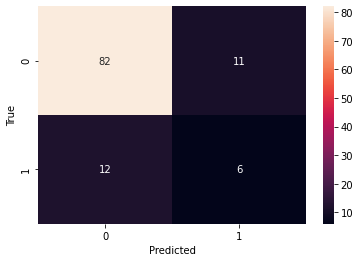

In [39]:
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

# 2.1 Neural Networks based classification

In [40]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer=keras.optimizers.Adam(0.001),
             loss='binary_crossentropy',
             metrics=keras.metrics.TrueNegatives())

In [43]:
model.fit(X_train, y_train, 
          epochs=50, batch_size=4, verbose=2,
         validation_split = 0.2, 
          callbacks=[keras.callbacks.EarlyStopping(patience=5, verbose=1),
                        keras.callbacks.ReduceLROnPlateau(factor=0.67, patience=5, verbose=1)])

Epoch 1/50
126/126 - 2s - loss: 0.5007 - true_negatives: 412.0000 - val_loss: 0.3383 - val_true_negatives: 112.0000 - lr: 0.0010 - 2s/epoch - 19ms/step
Epoch 2/50
126/126 - 0s - loss: 0.4523 - true_negatives: 414.0000 - val_loss: 0.3279 - val_true_negatives: 112.0000 - lr: 0.0010 - 360ms/epoch - 3ms/step
Epoch 3/50
126/126 - 0s - loss: 0.4333 - true_negatives: 414.0000 - val_loss: 0.3305 - val_true_negatives: 112.0000 - lr: 0.0010 - 367ms/epoch - 3ms/step
Epoch 4/50
126/126 - 0s - loss: 0.4223 - true_negatives: 414.0000 - val_loss: 0.3378 - val_true_negatives: 111.0000 - lr: 0.0010 - 418ms/epoch - 3ms/step
Epoch 5/50
126/126 - 0s - loss: 0.4083 - true_negatives: 411.0000 - val_loss: 0.3320 - val_true_negatives: 112.0000 - lr: 0.0010 - 429ms/epoch - 3ms/step
Epoch 6/50
126/126 - 0s - loss: 0.4017 - true_negatives: 409.0000 - val_loss: 0.3446 - val_true_negatives: 108.0000 - lr: 0.0010 - 430ms/epoch - 3ms/step
Epoch 7/50

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0006700

In [44]:
test_loss, test_acc = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 6ms/step - loss: 0.3396 - true_negatives: 90.0000


The neural network gives the probability of the classes instead of a discrete class value. To not be very strict with cluster exclusion I decided to categorize the probability > 0.3 as a cluster. Ofcourse this would require a follow up check on some lower probablity values but we would not at least miss the possible clusters.

True Positive(TP)  =  9
False Positive(FP) =  7
True Negative(TN)  =  86
False Negative(FN) =  9
precision score:  0.5
recall score:  0.5625
accuracy score:  0.8558558558558559


Text(33.0, 0.5, 'True')

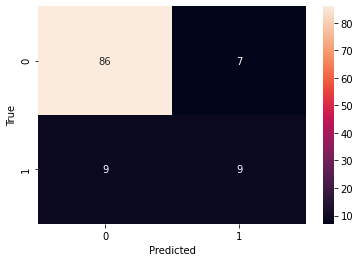

In [45]:
y_pred = model.predict(X_test)
for i in range(len(y_pred)):
    if y_pred[i] >= 0.3:
        y_pred[i] = int(1)
    else:
        y_pred[i] = int(0)
cm = confusion_matrix(y_test, y_pred)

TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

print('precision score: ', precision_score(y_pred, y_test))
print('recall score: ', recall_score(y_pred, y_test))
print('accuracy score: ', accuracy_score(y_pred, y_test))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

# 3.0 Summary

The best models from ML and Neural Network methods in binary classification present an accuracy around 85%, but we cannot solely depend on accuracy here as we have an imbalaced dataset. We must analyse the Receiver Operating Characteristic (ROC) curve and obtain optimum values for Precision and Recall despite the Precision Recall Tradeoff. The true negative values indeed produce a bug problem and I tried to reduce it by using the balanced accuracy and TrueNegatives as metrics during training. 

**Model summary (top 3 models):**

**Model 1: RandomForestClassifier after doing the grid search:**

Accuracy:  0.79 \
Precision:  0.33 \
Recall:  0.35

**Model 2: Naive Bayes**

Accuracy:  0.78 \
Precision:  0.38 \
Recall:  0.55

**Model 3: Neural Network with 2 hidden layer and an input and output layer with adaptive moments optimizer
and loss as binary crossentropy**

Precision: 0.5 \
Recall: 0.56 \
Accuracy: 0.85

The Neural Network model is promising with accuracy but it starts to overfit as the training is stopped early (see model.fit), so by collecting more data this model could do a better job than the current best model **Naive Bayes** which is based on Bayesian Probabilistic Classification and offers lesser chance to tune the parameters. Random Forest looks promising with accuracy but low precision means it gets biased too in the imbalanced dataset.

# **Conclusion:**

1. Collect more data
2. Fight imbalanced data